In [1]:
import sys  
sys.path.insert(0, '../')

import torch
import torch.nn as nn
import numpy as np
import os
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from feature_extraction import loan_struct_reader
from sklearn.datasets import make_blobs

from feature_extraction.loan_concatenator import LoanConcatenator
from feature_extraction.loan_markuper import LoanMarkuper
from feature_extraction.loan_options_maker import LoanOptionsMaker
from feature_extraction.loan_struct_reader import LoanStructReader

from bayes_opt import BayesianOptimization

import matplotlib.pyplot as plt

In [2]:
ROOT = os.path.dirname(os.getcwd())
FILES_DIR = os.path.join(ROOT, "json_augmented")
MARKUPFILE = os.path.join(FILES_DIR, r"markupdict0-2000.pckl")

In [3]:
# read etalon

json_example_path = os.path.join(ROOT, r"json_real", r"sample_1.json")
struct, original_options = LoanStructReader().Read(json_example_path, returnOptions=True)

In [4]:
# generate fake train_data

markuper = LoanMarkuper()
optionsMaker = LoanOptionsMaker()
markupdict = {}
for i in range(0, 300):
    options = optionsMaker.Make(original_options)

    js = LoanConcatenator(struct, options, {}).Parse()
    name = "sample_{}.json".format(i)
    LoanConcatenator.Save(js, os.path.join(ROOT, r"json_augmented", name))
    markupdict[name] = markuper.MarkupLoan(js)

In [5]:
# markup generated train_data

X, y = [], []
for file in os.listdir(FILES_DIR):
    if file.find("markupdict") != -1:
        with open(os.path.join(FILES_DIR, file), 'rb') as f:
            markupdict = pickle.load(f)
    else:
        _, options = loan_struct_reader.LoanStructReader().Read(os.path.join(FILES_DIR, file), returnOptions=True)
        X.append(options['irOptions_curve'])
        y.append(markupdict[file])
X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [6]:
print(y_train[:3], y_test[0], sep='\n')

[94140788.30399957 94475329.01214343 94038283.29726231]
93751272.85648513


In [7]:
y_ = 100000000

X_train, y_train = torch.FloatTensor(X_train), torch.FloatTensor(y_train / y_)
X_test, y_test = torch.FloatTensor(X_test), torch.FloatTensor(y_test / y_)

# Model Define

In [8]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = torch.nn.Linear(self.hidden_size, 1)
        
    def forward(self, x):
        hidden = self.fc1(x)
        relu = self.relu(hidden)
        dropped = self.dropout(relu)
        output = self.fc2(relu)
        return output

In [9]:
y_train

tensor([0.9414, 0.9448, 0.9404, 0.9397, 0.9407, 0.9390, 0.9407, 0.9389, 0.9439,
        0.9392, 0.9400, 0.9388, 0.9387, 0.9365, 0.9411, 0.9382, 0.9421, 0.9403,
        0.9389, 0.9405, 0.9392, 0.9409, 0.9392, 0.9388, 0.9403, 0.9396, 0.9357,
        0.9380, 0.9397, 0.9392, 0.9405, 0.9383, 0.9421, 0.9392, 0.9365, 0.9375,
        0.9411, 0.9416, 0.9405, 0.9369, 0.9396, 0.9427, 0.9416, 0.9387, 0.9397,
        0.9388, 0.9394, 0.9387, 0.9401, 0.9402, 0.9380, 0.9404, 0.9414, 0.9365,
        0.9409, 0.9371, 0.9422, 0.9410, 0.9392, 0.9350, 0.9401, 0.9386, 0.9429,
        0.9382, 0.9419, 0.9422, 0.9404, 0.9411, 0.9392, 0.9433, 0.9394, 0.9420,
        0.9396, 0.9417, 0.9372, 0.9394, 0.9377, 0.9375, 0.9381, 0.9392, 0.9433,
        0.9396, 0.9383, 0.9389, 0.9411, 0.9412, 0.9373, 0.9358, 0.9408, 0.9383,
        0.9414, 0.9375, 0.9390, 0.9393, 0.9390, 0.9379, 0.9427, 0.9393, 0.9397,
        0.9386, 0.9413, 0.9416, 0.9424, 0.9409, 0.9406, 0.9378, 0.9371, 0.9411,
        0.9420, 0.9410, 0.9427, 0.9398, 

# Training

In [105]:
model = Net(10, 50000)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

train_info = {'mae_train': [], 'mae_test': [], 'loss_train': []}

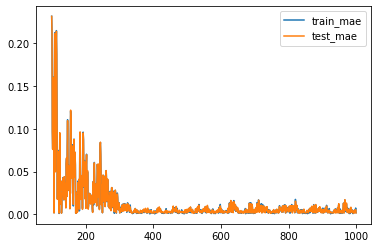

In [106]:
step_size = 5

for epoch in range(1000):
    train_indexes = np.random.choice(range(len(X_train)), size=step_size)
    model.train()
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(X_train[train_indexes])
    # Compute Loss
    loss = criterion(y_pred.squeeze(), y_train[train_indexes])
    train_info['loss_train'].append(loss.item())
    
    if int(batch_start / step_size) % 10 == 0: print('Epoch {}: train loss: {}'.format(int(batch_start / step_size), loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()
    
    model.eval()
    train_pred = model(X_train[train_indexes]).squeeze().detach().numpy() * y_
    train_true = y_train[train_indexes].numpy() * y_
    train_info['mae_train'].append(np.mean(np.abs(train_pred - train_true) / train_true))    
    
    test_pred = model(X_test).squeeze().detach().numpy() * y_
    test_true = y_test.numpy() * y_
    train_info['mae_test'].append(np.mean(np.abs(test_pred - test_true) / test_true))

# plt.plot(np.arange(len(train_info['loss_train'])), np.array(train_info['loss_train']), label='train_loss')
plt.plot(np.arange(len(train_info['mae_train']))[100:], np.array(train_info['mae_train'])[100:], label='train_mae')
plt.plot(np.arange(len(train_info['mae_test']))[100:], np.array(train_info['mae_test'])[100:], label='test_mae')
plt.legend()
plt.show()

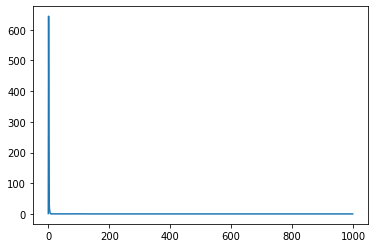

In [107]:
plt.plot(np.arange(len(train_info['loss_train'])), np.array(train_info['loss_train']), label='train_loss')

In [108]:
np.mean(train_info['mae_test'][-50:])

0.005195793786663227

In [38]:
model.eval()
y_pred = model(X_test)
after_train = criterion(y_pred.squeeze(), y_test) 
print('Test loss after Training' , after_train.item())

Test loss after Training 0.7465307712554932


In [39]:
model = Net(10, 50000)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05)

In [44]:
step_size = 5
train_info = {'mae_train': [], 'mae_test': [], 'loss_train': []}
best_model = model

for X_train_size in range(step_size, len(X_train), step_size):
    cur_X_train = X_train[:X_train_size]
    cur_y_train = y_train[:X_train_size]   

    prev_mape = np.inf
    early_stop_count = 0
    model = best_model
    
    for epoch in range(1000):
        train_indexes = np.random.choice(range(len(cur_X_train)), size=step_size)
        
        model.train()
        optimizer.zero_grad()
        # Forward pass
        y_pred = model(cur_X_train[train_indexes])
        
        # Compute Loss
        loss = criterion(y_pred.squeeze(), cur_y_train[train_indexes])

        loss.backward()
        optimizer.step()

        model.eval()

        test_pred = model(X_test).squeeze().detach().numpy() * y_
        test_true = y_test.numpy() * y_
        
        
        if np.mean(np.abs(test_pred - test_true) / test_true) >= prev_mape:
            early_stop_count += 1
        else:
            early_stop_count = 0
            prev_mape = np.mean(np.abs(test_pred - test_true) / test_true)
            best_model = model
           
        if early_stop_count >= 10:
            print(epoch)
            break
            
    train_info['mae_test'].append(prev_mape)

17
12
32
17
19
19
28
12
13
14
22
11
18
10
18
18
16
14
31
27
17
15
21
16
15
12
23
10
15
37
18
22
17
20
15
11
11
11
13
11


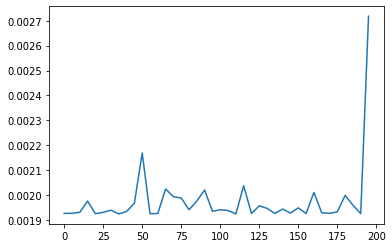

In [45]:
plt.plot(np.arange(len(train_info['mae_test'])) * 5, np.array(train_info['mae_test']), label='test_mae')

In [46]:
np.array(train_info['mae_test'])

array([0.00192555, 0.00192605, 0.00193007, 0.00197525, 0.00192455,
       0.00193004, 0.00193854, 0.0019236 , 0.00193343, 0.00196678,
       0.00216851, 0.00192442, 0.00192529, 0.00202384, 0.00199296,
       0.00198773, 0.00194023, 0.00197561, 0.00201962, 0.001934  ,
       0.00194043, 0.00193753, 0.00192359, 0.00203671, 0.00192537,
       0.00195618, 0.00194586, 0.00192567, 0.00194307, 0.00192696,
       0.00194793, 0.00192511, 0.00200998, 0.00192815, 0.00192612,
       0.00193187, 0.00199809, 0.00195882, 0.00192457, 0.0027182 ])